<a href="https://colab.research.google.com/github/lucasgneccoh/SGD_ICP_PY/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install authors implementation

In [ ]:
%%capture
%cd /content
!git clone https://bitbucket.org/fafz/sgd_icp.git
!sudo apt install libeigen3-dev
!sudo apt install libpcl-dev
%cd /content/sgd_icp
!mkdir build
%cd build
!cmake -DCMAKE_BUILD_TYPE=Release /content/sgd_icp
!make

# Project - SGD ICP in python

In [2]:
%%capture
%cd /content
!git clone https://github.com/lucasgneccoh/SGD_ICP_PY.git
!pip install lzf
'''
Setup pypcd
'''
%cd /content/SGD_ICP_PY/pypcd/
!python setup.py build
!python setup.py install

In [261]:
import os
import numpy as np
from pypcd import pypcd as pcd
from google.colab import files
import json
import matplotlib.pyplot as plt


def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

def pitch_roll_yaw(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  R = np.array([[cz*cy, cz*sx*sy-sz*cx, cz*sx*sy+sz*sy],
                [sz*cy, sz*sx*sy+cz*cx, sz*sx*sy-cz*sx],
                [-sy, cy*sx, cy*cx]])
  return R

def roll_pitch_yaw(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  R = np.array([[cy*cz, -cy*sz, sy],
                [sx*sy*cz+cx*sz, -sx*sy*sz+cx*cz, -sx*cy],
                [-cx*sy*cz + sx*sz, cx*sy*sz+sx*cz, cx*cy]])
  return R

def d_R(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  d_roll = np.array([[0, 0, 0],
                [cx*sy*cz-sx*sz, -cx*sy*sz-sx*cz, -cx*cy],
                [sx*sy*cz + cx*sz, -sx*sy*sz+cx*cz,-sx*cy]])
  d_pitch = np.array([[-sy*cz, sy*cz, cy],
                [sx*cy*cz, -sx*cy*sz, sx*sy],
                [-cx*cy*cz, cx*cy*sz, -cx*sy]])
  d_yaw = np.array([[-cy*sz, -cy*cz, 0],
                [-sx*sy*sz+cx*cz, -sx*sy*cz-cx*sz, 0],
                [cx*sy*sz + sx*cz, cx*sy*cz-sx*sz, 0]])
  return d_roll, d_pitch, d_yaw


def add_noise(pc, mean, std):
  return pc + np.random.normal(loc=mean, scale=std, size=pc.shape)

def apply_transform(pc, R, t):
  if isinstance(pc, pcd.PointCloud):
    cloud = np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])
    cloud = R.T @ cloud + t.reshape(-1,1)
    for a, i in zip(['x', 'y', 'z'], range(3)):
      pc.pc_data[a] = cloud[i,:]
  else:
    pc = R.T @ pc +  t.reshape(-1,1)    
  return pc

def apply_transform_from_theta(pc, theta):
  R, T = theta_to_tranformation(theta)
  return apply_transform(pc, R, T)


def roll_pitch_yaw(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  R = np.array([[cz*cy, cz*sx*sy-sz*cx, cz*sx*sy+sz*sy],
                [sz*cy, sz*sx*sy+cz*cx, sz*sx*sy-cz*sx],
                [-sy, cy*sx, cy*cx]])
  return R

def theta_to_tranformation(theta):
  R, T = roll_pitch_yaw(*theta[3:]), theta[:3].copy().reshape(-1,1)
  return R, T

def gradient(source, ref, theta):
  R, T = theta_to_tranformation(theta)
  ins = (R @ source + T) - ref # 3 x M
  # w.r.t T, it is already in ins
  # w.r.t R  
  # Fast way !Wrong
  # super_dR = np.array([d_R(*theta[3:])]).reshape(3,3,3)
  # D = (super_dR @ source)*ins
  # D = D.sum(axis=0).mean(axis=-1)
  # print(D)
  # Slow but sure
  dr, dp, dy = d_R(*theta[3:])
  D = np.array([((a @ source)*ins).sum(0).mean() for a in [dr, dp, dy]])
  # print(D)

  return np.hstack([2*ins.mean(axis=1), 2*D]) 

def read_pcd(path):
  pc = pcd.point_cloud_from_path(path)
  return np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])

def dropout(cloud, drop_prop):
  ind = (np.random.uniform(size=cloud.shape[1])>drop_prop)
  return cloud[:,ind]

def normalize(cloud, eps=1e-4):
  M, m = cloud.max(1), cloud.min(1)
  dif = np.maximum(M-m,eps).reshape(-1,1)
  return (cloud - m.reshape(-1,1))/dif

def crop_cloud_sphere(cloud, radius):
  ind = (np.linalg.norm(cloud, axis=0)<radius)
  return cloud[:,ind]

def save_whole_cloud(paths_in, path_out):
  start = True
  whole = None
  for path_in in paths_in:
    pc = pcd.point_cloud_from_path(path_in)
    meta = pc.get_metadata()
    trans = np.array(meta['viewpoint'][:3])
    rot = quaternion_rotation_matrix(meta['viewpoint'][3:]).T
    
    cloud = np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])
    
    rotated = rot.T @ cloud + trans.reshape(-1,1)
    
    pc.pc_data['x'] = rotated[0,:]
    pc.pc_data['y'] = rotated[1,:]
    pc.pc_data['z'] = rotated[2,:]
    if start:
      start = False
      whole = pc
    else:
      whole = pcd.cat_point_clouds(whole, pc)
      
  whole.save_pcd(path_out)

In [4]:
roll, pitch, yaw = np.pi/2, np.pi/2, 0
v = np.array([0,0,1])
v_trans = v @ roll_pitch_yaw(roll, pitch, yaw)
print("Orig: ", v)
print("Trans: ", v_trans)

Orig:  [0 0 1]
Trans:  [-6.12323400e-17  1.00000000e+00  3.74939946e-33]


In [4]:
'''
Build an unified cloud using different parts from the Bremen dataset
'''
%cd /content/SGD_ICP_PY
parts = [0, 1]
path_out = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'

paths_in = ['/content/SGD_ICP_PY/data/pcd_bremen/pcd_bremen/scan_0{0:02d}.pcd'.format(i) for i in parts]
save_whole_cloud(paths_in, path_out)
# files.download(path_out) 

/content/SGD_ICP_PY


In [5]:
# Create a copy but rotated and translated to try to align them
x, y, z, roll, pitch, yaw = 1,3,0,0,0,np.pi/6
R, t = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
pc = pcd.point_cloud_from_path(path_out)
pc = apply_transform(pc, R, t)

path_out_mod = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_mod.pcd'
pc.save_pcd(path_out_mod)
# files.download(path_out_mod)

In [6]:
'''
This cell tests the authors code using the clouds defined before
'''

if False: # This can take time 
  # Prepare config file
  with open('/content/sgd_icp/config.json') as f:
    config_dict = json.load(f)
  config_dict['normalize-cloud'] = True
  initial_guess = {'x': -1.0, 'y': -3.0, 'z': 0.0, 'roll': 0.0, 'pitch': 0.0, 'yaw': round(np.pi/6,3)}
  config_dict['initial-guess'] = initial_guess

  config_path = '/content/sgd_icp/my_config.json'
  with open(config_path, 'w') as f:
    json.dump(config_dict, f)
  # Test here. Uses PCD format for the clouds. Config file example is given in repository: JSON file with parameters
  # align_pcd <source_cloud> <target_cloud> <cofig_file>
  %cd /content/sgd_icp/bin
  config_def = '/content/sgd_icp/config.json'
  !./align_pcd $path_out $path_out_mod $config_def

In [ ]:
%cd /content/SGD_ICP_PY
# This values are the output of the sgd_icp method
x, y, z, roll, pitch, yaw = 0.859752,2.4057,-1.50104,0.298771,-0.998264,-0.386195
R, t = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
pc = pcd.point_cloud_from_path(path_out)
apply_transform(pc, R, t)
pc.save_pcd('./data/pcd_bremen/my_bremen_sgd_icp.pcd')
# files.download('./data/pcd_bremen/my_bremen_sgd_icp.pcd')

# Python implementation using the code from class

In [259]:
#
#
#      0===================================0
#      |    TP2 Iterative Closest Point    |
#      0===================================0
#
#
#------------------------------------------------------------------------------------------
#
#      Script of the practical session
#
#------------------------------------------------------------------------------------------
#
#      Hugues THOMAS - 17/01/2018
#


#------------------------------------------------------------------------------------------
#
#          Imports and global variables
#      \**********************************/
#



%cd /content/SGD_ICP_PY/sgd_icp_python
# Import numpy package and name it "np"
import numpy as np

# Import library to plot in python
from matplotlib import pyplot as plt

# Import functions from scikit-learn
from sklearn.neighbors import KDTree

# Import functions to read and write ply files
from ply_utils import write_ply, read_ply
from visu import show_ICP
import time



#------------------------------------------------------------------------------------------
#
#           Functions
#       \***************/
#
#
#   Here you can define usefull functions to be used in the main
#


def best_rigid_transform(data, ref):
    '''
    Computes the least-squares best-fit transform that maps corresponding points data to ref.
    Inputs :
        data = (d x N) matrix where "N" is the number of points and "d" the dimension
         ref = (d x N) matrix where "N" is the number of points and "d" the dimension
    Returns :
           R = (d x d) rotation matrix
           T = (d x 1) translation vector
           Such that R * data + T is aligned on ref
    '''
    
    
    p = ref.mean(1).reshape(-1,1)
    p_prime = data.mean(1).reshape(-1,1)    
    U, S, V = np.linalg.svd((data-p_prime) @ (ref-p).T, full_matrices=False)
    V = V.T
    R = V @ U.T
    if np.linalg.det(R)<0:
        U[:,-1] *= -1
        R = V @ U.T
    
    T = p - R @ p_prime
    return R, T.reshape(-1,1)


def icp_point_to_point(data, ref, max_iter, RMS_threshold, show_progress=False):
    '''
    Iterative closest point algorithm with a point to point strategy.
    Inputs :
        data = (d x N_data) matrix where "N_data" is the number of points and "d" the dimension
        ref = (d x N_ref) matrix where "N_ref" is the number of points and "d" the dimension
        max_iter = stop condition on the number of iterations
        RMS_threshold = stop condition on the distance
    Returns :
        data_aligned = data aligned on reference cloud
        R_list = list of the (d x d) rotation matrices found at each iteration
        T_list = list of the (d x 1) translation vectors found at each iteration
        neighbors_list = At each iteration, you search the nearest neighbors of each data point in
        the ref cloud and this obtain a (1 x N_data) array of indices. This is the list of those
        arrays at each iteration
           
    '''

    # Variable for aligned data
    data_aligned = np.copy(data)
    
    # Initiate lists
    R_list = []
    T_list = []
    neighbors_list = []
    RMS_list = []
    tree = KDTree(ref.T)
    for i in range(max_iter):
        # Match points
        ind = tree.query(data_aligned.T, return_distance=False).squeeze()
        #ICP
        R, T = best_rigid_transform(data, ref[:,ind])
        data_aligned = R @ data + T
        neighbors_list.append(ind)        
        R_list.append(R)
        T_list.append(T)
        rms = RMS(data_aligned, ref[:,ind])
        RMS_list.append(rms)
        if show_progress: print('{:.3f}'.format(rms))
        if rms < RMS_threshold: break
    return data_aligned, R_list, T_list, neighbors_list, RMS_list

def icp_point_to_point_fast(data, ref, max_iter, RMS_threshold, sampling_limit, resample=False, show_progress=False):
    '''
    Iterative closest point algorithm with a point to point strategy.
    Inputs :
        data = (d x N_data) matrix where "N_data" is the number of points and "d" the dimension
        ref = (d x N_ref) matrix where "N_ref" is the number of points and "d" the dimension
        max_iter = stop condition on the number of iterations
        RMS_threshold = stop condition on the distance
    Returns :
        data_aligned = data aligned on reference cloud
        R_list = list of the (d x d) rotation matrices found at each iteration
        T_list = list of the (d x 1) translation vectors found at each iteration
        neighbors_list = At each iteration, you search the nearest neighbors of each data point in
        the ref cloud and this obtain a (1 x N_data) array of indices. This is the list of those
        arrays at each iteration
           
    '''

    # Variable for aligned data
    data_aligned = np.copy(data)
    
    # Initiate lists
    R_list = []
    T_list = []
    neighbors_list = []
    RMS_list = []
    tree = KDTree(ref.T)
    data_sample_ind = np.random.choice(data.shape[1], size= min(data.shape[1],sampling_limit), replace=False)
    for i in range(max_iter):
        if resample:
            # Sample
            data_sample_ind = np.random.choice(data.shape[1], size= min(data.shape[1],sampling_limit), replace=False)
        
    
        # Match points
        ind = tree.query(data_aligned[:,data_sample_ind].T, return_distance=False).squeeze()
        #ICP
        R, T = best_rigid_transform(data[:,data_sample_ind], ref[:,ind])
        
        data_aligned = R @ data + T
        
        neighbors_list.append((data_sample_ind,ind))        
        R_list.append(R)
        T_list.append(T)
        ind = tree.query(data_aligned.T, return_distance=False).squeeze()
        rms = RMS(data_aligned, ref[:,ind])
        RMS_list.append(rms)
        if show_progress: print('{:.3f}'.format(rms))
        if rms < RMS_threshold: break
    
    return data_aligned, R_list, T_list, neighbors_list, RMS_list


def sgd_icp(source, ref, epochs, RMS_threshold, batch_size, dmax,
            show_progress=False, eval_every = 1, theta_init=None,
            alpha = lambda i: 0.001, beta1=0.9, beta2=0.999, eps=1e-6,
            resample=False):
    '''
    Iterative closest point algorithm using sgd
    Inputs :
        source = (d x N_source) matrix where "N_source" is the number of points and "d" the dimension
        ref = (d x N_ref) matrix where "N_ref" is the number of points and "d" the dimension
        epochs = stop condition on the number of iterations
        RMS_threshold = stop condition on the distance
    Returns :
        data_aligned = data aligned on reference cloud
        R_list = list of the (d x d) rotation matrices found at each iteration
        T_list = list of the (d x 1) translation vectors found at each iteration
        neighbors_list = At each iteration, you search the nearest neighbors of each data point in
        the ref cloud and this obtain a (1 x N_data) array of indices. This is the list of those
        arrays at each iteration
           
    '''
    # Initiate lists
    R_list, T_list, norms_list, RMS_list, rms = [], [], [], [], 0     
    tree, N = KDTree(ref.T), source.shape[1]    
    indices, total_time, last_epoch_time = np.arange(N), 0, 0   
    beta1t, beta2t = beta1, beta2

    if theta_init is None:
      theta = np.zeros(6)
    else:
      theta = theta_init.copy()

    m, v = np.zeros_like(theta), np.zeros_like(theta)
    mhat, vhat = np.zeros_like(theta), np.zeros_like(theta)

    for i in range(epochs):
      start = time.process_time()
      
      # Shuffle the indices
      np.random.shuffle(indices)
      
      for b in range(N//batch_size):
        # print(f'\tBatch {b} out of {N//batch_size}')
        if resample:
          batch_ind = np.random.choice(N, batch_size, replace=False)
        else:
          batch_ind = indices[batch_size*b:batch_size*(b+1)]
    
        # Match points
        R, t = theta_to_tranformation(theta)
        transformed = apply_transform(source[:,batch_ind], R, t)
        batch_ind, ind = match_points(transformed, batch_ind, tree, dmax = dmax)
        
        if len(batch_ind)==0: continue
        #ICP
        # R, T = best_rigid_transform(source[:,batch_ind], ref[:,ind])
        
        #SGD_ICP
        grad = gradient(source[:,batch_ind], ref[:,ind], theta)
        norms_list.append(np.linalg.norm(grad))
        m, v = beta1*m + (1-beta1)*grad, beta2*v + (1-beta2)*grad*grad        
        mhat, vhat = m/(1-beta1t), v/(1-beta2t)
        beta1t *= beta1
        beta2t *= beta2
        if beta2 > 0:
          sgd = mhat / (np.sqrt(vhat)+eps)
        else:
          sgd = mhat
        theta = theta - alpha(i)*sgd
              
      R, T = theta_to_tranformation(theta)
      R_list.append(R)
      T_list.append(T)
      if (i+1)%eval_every==0:        
        # Compute RMS
        R, t = theta_to_tranformation(theta)
        transformed = apply_transform(source, R, t)
        ind = tree.query(transformed.T, return_distance=False).squeeze()
        rms = RMS(transformed, ref[:,ind])
        RMS_list.append(rms)
        if show_progress:
          print(f'Epoch {i:02d}:\ntotal time: {total_time:.1f}s\tlast epoch: {last_epoch_time:.1f}s\trms: {rms:.3f}')
        
        if rms < RMS_threshold: break
      last_epoch_time = time.process_time() - start
      total_time += last_epoch_time
    R, t = theta_to_tranformation(theta)
    transformed = apply_transform(source, R, t)
    return transformed, R_list, T_list, norms_list, RMS_list

def match_points(transformed, batch_ind, tree, dmax = np.inf):
  dist, ind = tree.query(transformed.T, return_distance=True)
  dist, ind  = dist.squeeze(), ind.squeeze()
  return batch_ind[(dist<dmax)], ind[(dist<dmax)]

def RMS(c1, c2):
    return np.sqrt(np.mean(np.sum(np.power(c1 - c2, 2), axis=0)))

#------------------------------------------------------------------------------------------
#
#           Main
#       \**********/
#
#
#   Here you can define the instructions that are called when you execute this file
#

def read_ply_file(path, fields):
  ply_cloud = read_ply(path)
  return np.vstack([ply_cloud[f] for f in fields])  
 

/content/SGD_ICP_PY/sgd_icp_python


In [ ]:
'''
Testing the ICp code
'''
   
if False:
  print("*************** ICP 3D ******************")
  # Cloud paths
  bunny_o_path = '../data/bunny_original.ply'
  bunny_p_path = '../data/bunny_perturbed.ply'
  
  # Load clouds
  bunny_o = read_ply_file(bunny_o_path, ['x','y','z'])
  bunny_p = read_ply_file(bunny_p_path, ['x','y','z'])
  
  # Apply ICP
  bunny_p_opt, R_list, T_list, neighbors_list, RMS_list = icp_point_to_point(bunny_p, bunny_o, 25, 1e-4)
  
  # Show ICP
  prop = 0.3
  l_p, l_o = bunny_p.shape[1], bunny_o.shape[1]
  sample_p = bunny_p[:,np.random.choice(l_p, int(prop*l_p), replace=False)] 
  sample_o = bunny_o[:,np.random.choice(l_o, int(prop*l_o), replace=False)]
  show_ICP(sample_p, sample_o, R_list, T_list, neighbors_list)
  
  # Plot RMS
  plt.figure()
  plt.plot(RMS_list)
  plt.title("RMS for the 3D bunny example")
  plt.xlabel("iteration")
  plt.ylabel("RMS value")
  plt.show()

if False:

  ''' Using samples instead of whole clouds'''
  print("*************** ICP 3D with sample ******************")
  sample_size = 1000
  resample = True
  # Cloud paths
  nd_ref_path = '../data/Notre_Dame_Des_Champs_1.ply'
  nd_data_path = '../data/Notre_Dame_Des_Champs_2.ply'
  
  # Load clouds
  nd_data = read_ply(nd_ref_path)
  nd_ref = read_ply(nd_data_path)
  
  # Apply ICP
  nd_opt, R_list, T_list, neighbors_list, RMS_list = icp_point_to_point_fast(nd_data, nd_ref, 15, 1e-4, sample_size, resample=resample)
  
  # Show ICP
  # show_ICP(bunny_p, bunny_o, R_list, T_list, neighbors_list)
  
  # Apply the tranformation
  nd_opt = R_list[-1] @ nd_data + T_list[-1]
  
  # Save cloud
  write_ply('../nd_opt', [nd_opt.T], ['x', 'y', 'z'])
  
  
  # Plot RMS
  plt.figure()
  plt.plot(RMS_list)
  plt.title("RMS for the Notre Dame (with sampling of {} points)\nResample={}".format(sample_size, resample))
  plt.xlabel("iteration")
  plt.ylabel("RMS value")
  plt.show()
  
if True:
  print("*************** SGD ICP 3D ******************")
  # Load Clouds
  nd_ref_path = '../data/Notre_Dame_Des_Champs_1.ply'
  nd_data_path = '../data/Notre_Dame_Des_Champs_2.ply'
  nd_ref = read_ply_file(nd_ref_path, ['x','y','z'])
  nd_data= read_ply_file(nd_data_path, ['x','y','z'])
  
  
  data_aligned, R_list, T_list, _, RMS_list = sgd_icp(nd_data, nd_ref, 10, 1e-4, batch_size=int(nd_data.shape[1]//10), dmax=0.5*10000000, show_progress=True, eval_every=3)
  
  plt.plot(RMS_list)

In [258]:
%cd /content/SGD_ICP_PY/sgd_icp_python
import ICP
from ply_utils import read_ply
from visu import show_ICP
# source = normalize(read_pcd('../data/pcd_bremen/my_bremen.pcd'))
source = normalize(read_ply_file('../data/bunny_original.ply', ['x','y','z']))

theta_orig = np.array([0,0,0,0,0,np.pi/3])
R, t = theta_to_tranformation(theta_orig)
ref = apply_transform(source, R, t)

/content/SGD_ICP_PY/sgd_icp_python


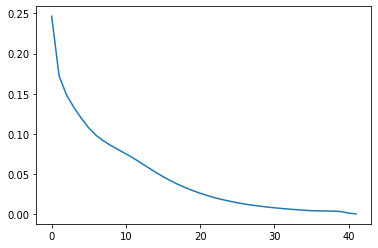

In [251]:
'''
Both clouds are in correspondence, so the naive ICP will work.
This functions assumes the clouds are already matched
'''
icp_cloud, R_list, T_list, _, RMS_list = icp_point_to_point(source, ref, 50, 1e-4, show_progress=False)
plt.plot(RMS_list)

In [ ]:
'''
Now lets shuffle the clouds and try again
'''
np.random.shuffle(ref.T)
icp_cloud_shuffle, R_list_shuffle, T_list_shuffle, _, RMS_list_shuffle = \
  icp_point_to_point(source, ref, 50, 1e-4, show_progress=False)
plt.plot(RMS_list_shuffle)

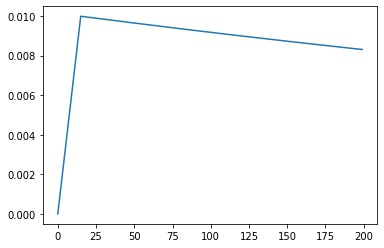

In [252]:
init, warm_up, decay = 0.01, 15, 0.999
epochs = 200
warm_up_decay = lambda i: i*(init/warm_up) if i < warm_up  else init*decay**(int((i-warm_up+1)))
y = np.array([alpha(i) for i in np.arange(epochs)])
plt.plot(y)

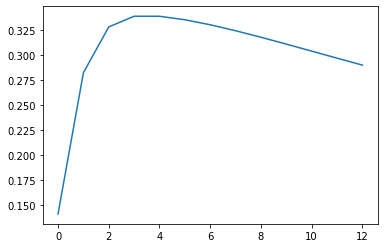

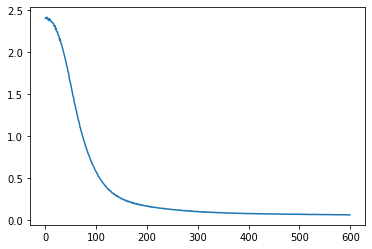

In [260]:
'''
Let's try SGD
'''
theta_init = add_noise(theta_orig,0,0.001)
icp_cloud_sgd, R_list_sgd, T_list_sgd, norms_list, RMS_list_sgd = sgd_icp(source, ref, epochs, 1e-4,
            batch_size=10000, dmax=1,
            show_progress=False, eval_every = 15, theta_init=theta_init,
            alpha = warm_up_decay, beta1=0, beta2=0, eps=1e-6,
            resample=False)
plt.plot(RMS_list_sgd)
plt.show()
plt.plot(norms_list)
plt.show()

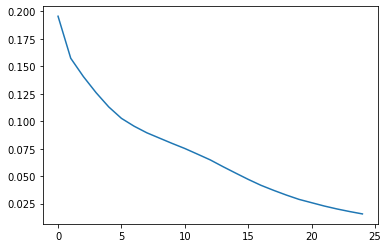

In [254]:
sample_size = 2000
resample = True
'''
TODO: Test the one with the sampling
TODO: Implement the SGD one
TODO: Maybe implement it with torch, using either autograd or plain backprop
'''
np.random.shuffle(ref.T)
icp_sample, R_list_sample, T_list_sample, _, RMS_list_sample = icp_point_to_point_fast(source, ref, 25, 1e-4, sample_size, resample=resample, show_progress=False)
plt.plot(RMS_list_sample)

In [ ]:
import plotly.express as px
import pandas as pd
sp = dropout(source, 0.5)
rp = dropout(ref, 0.5)
R, T = theta_to_tranformation(theta_init)
tp = apply_transform(sp, R, T)
tp = dropout(icp_cloud_sgd, 0.5)
df = pd.concat([pd.DataFrame(data={'cloud':'source','x':sp[0,:],'y':sp[1,:],'z':sp[2,:]}),
                pd.DataFrame(data={'cloud':'ref','x':rp[0,:],'y':rp[1,:],'z':rp[2,:]}),
                pd.DataFrame(data={'cloud':'icp','x':tp[0,:],'y':tp[1,:],'z':tp[2,:]})])
df['size'] = 3
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='cloud')
fig.show()

In [318]:
source = np.array([0,0,1]).reshape(3,1)
sq = np.sqrt(3)
ref = np.array([1/sq,1/sq,1/sq]).reshape(3,1)
theta = np.zeros(6)

theta = theta-0.1*gradient(source, ref, theta)
res = apply_transform_from_theta(source, theta)
print(res)


[[0.12187565]
 [0.06336376]
 [0.56875611]]
